# Some Experiments
used for some shit

## Imports

In [6]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [7]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

# own classes
from data_generation.algorithmic.brownian_motion import brownian_motion
from data_generation.algorithmic.jittering import create_jittered_time_series
from data_generation.algorithmic.time_warping import create_time_warped_data
from utilities import save_unscaled_sequential_data, load_sequential_time_series

In [8]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" 
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

## Stuff

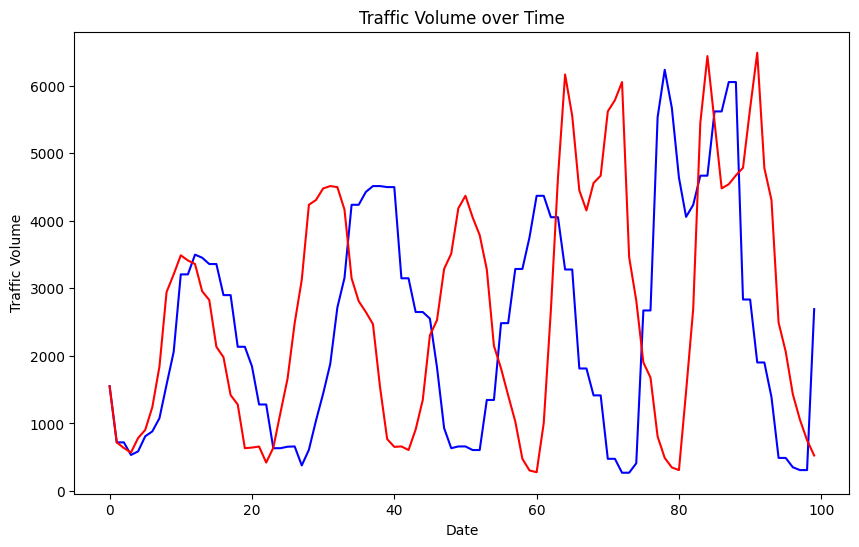

In [9]:
train = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_1y.csv")
test = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_3mo.csv")

timewarped = pd.read_csv(SYNTHETIC_DATA_FOLDER / "usable" / "1y" / "time_warped.csv")
jittered = pd.read_csv(SYNTHETIC_DATA_FOLDER / "usable" / "1y" / "jittered_01.csv")

no = 100
attribute = "traffic_volume"
plt.figure(figsize=(10, 6))
plt.plot(train[attribute][:no], color='blue')
plt.plot(timewarped[attribute][:no], color='red')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume over Time')
plt.show()

In [10]:
save_unscaled_sequential_data(ori_data_path=REAL_DATA_FOLDER / "mitv_prep_1y.csv",
                                scaled_data_path=SYNTHETIC_DATA_FOLDER / "raw" / "1y" / "8747_12_5_timegan_lstm_16_2_20k_64_raw.csv",
                                scaled_data_shape=(8747, 12, 5),
                                no_features_to_inverse_scale=5)

In [23]:
df = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / "usable" / "1y" / "8747_12_5_timegan_lstm.csv", shape=(8747, 12, 5))

In [24]:
df = pd.DataFrame(df.reshape(-1, 5))

In [25]:
df.describe()

,0,1,2,3,4
count,104964.000000,104964.000000,104964.000000,104964.000000,104964.000000
mean,3198.733834,283.343847,0.034189,0.000067,41.705959
std,1932.971896,11.756874,0.209961,0.000296,38.665880
min,47.574738,254.165840,0.000000,0.000000,0.081840
25%,1184.408617,271.283047,0.000009,0.000000,0.830981
50%,3710.620576,285.982410,0.000434,0.000000,26.513073
75%,4926.550740,293.681594,0.004199,0.000044,85.799234
max,6459.405012,304.359551,5.326140,0.007977,97.120476


In [26]:
train.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,3244.668912,282.208136,0.086792,0.000233,44.397306
std,1946.247953,12.114907,0.901360,0.006145,39.195308
min,0.000000,243.390000,0.000000,0.000000,0.000000
25%,1252.500000,273.605500,0.000000,0.000000,1.000000
50%,3402.000000,283.650000,0.000000,0.000000,40.000000
75%,4849.500000,292.060000,0.000000,0.000000,90.000000
max,7260.000000,307.330000,42.000000,0.250000,100.000000
